In [1]:
import tesstest
import tesstrain
from os import listdir
from os.path import join, isfile

In [2]:
# see ./Dockerfile (scribble_train base image) for more information on the file structure inside this container
TEST_PATH = '/train/tesstrain/data/kaggle-ground-truth' 
model_name = "kaggle"
tessdata="/train/tessdata"

In [3]:
# train a tesseract model for OCR
# see ./structured_experiments/2022.08.18.notebook_template/mytesseract/tesstrain/__init__.py for implementation
tesstrain.train_tesseract("/train/tesstrain",  model_name=model_name, start_model="eng", tessdata=tessdata, max_iterations=100)

Running C code (via make) to train a tesseract model: cd /train/tesstrain && make training TESSDATA_FOLDER=/train/tessdata MODEL_NAME=kaggle START_MODEL=eng TESSDATA=/train/tessdata MAX_ITERATIONS=100


Loaded file data/kaggle/checkpoints/kaggle_checkpoint, unpacking...
Successfully restored trainer from data/kaggle/checkpoints/kaggle_checkpoint
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0404.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0411.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0409.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0439.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0420.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0395.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0399.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0432.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0401.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0373.lstmf
Loaded 1/1 lines (1-1) of document data/kaggle-ground-truth/TEST_0382.lstmf
At iteration 99/100

cp /train/tessdata/eng.traineddata /train/tesstrain/data/eng.traineddata
cp -R /train/tessdata/configs /train/tesstrain/data/configs
lstmtraining \
  --debug_interval 0 \
  --traineddata data/kaggle/kaggle.traineddata \
  --old_traineddata /train/tessdata/eng.traineddata \
  --continue_from data/eng/kaggle.lstm \
  --learning_rate 0.0001 \
  --model_output data/kaggle/checkpoints/kaggle \
  --train_listfile data/kaggle/list.train \
  --eval_listfile data/kaggle/list.eval \
  --max_iterations 100 \
  --target_error_rate 0.01
lstmtraining \
--stop_training \
--continue_from data/kaggle/checkpoints/kaggle_checkpoint \
--traineddata data/kaggle/kaggle.traineddata \
--model_output data/kaggle.traineddata




In [4]:
# get a random sample of images from TEST_PATH folder and read their ground truth files (labels with correct OCR)
test_image_paths = []
test_image_labels = []
count = 0

for file_name in listdir(TEST_PATH):
    file_path = join(TEST_PATH, file_name)
    if count < 100 and file_path.endswith(".png") and isfile(file_path):
        
        ground_truth_path = file_path.replace(".png", ".gt.txt")
        if isfile(file_path) and isfile(ground_truth_path):
            test_image_paths.append(file_path)
            with open(ground_truth_path, mode='r') as f:
                ground_truth = f.read()
            test_image_labels.append(ground_truth)
            count += 1
    else:
        continue
print(test_image_paths[:2], test_image_labels[:2])

['/train/tesstrain/data/kaggle-ground-truth/TEST_0370.png', '/train/tesstrain/data/kaggle-ground-truth/TEST_0371.png'] ['LE CAM', 'CASSANDRA']


In [5]:
# generate word error rate and character error rate for model based on random sample generated above
# see ./structured_experiments/2022.04.28.notebook_template/mytesseract/tesstrain/__init__.py for implementation
word_error_rate, char_error_rate, test_extractions, test_image_labels, image_list = tesstest.test_model("kaggle", tessdata, test_image_paths, test_image_labels)

word_error_rate, char_error_rate: 1.0470588235294118 0.8042635658914729


images


,images,labels,extractions(model_output),character_error_rate
39,,FLAVIE,PRENOM\n\nFLAVIE\nRETENRAIRRANAE VASRE\n,4.833333
74,,ENZO,NM:ENLOD\n\nS VANA RRSRL\n\n \n,4.750000
71,,CORENTIN,PRENOM\n\nCORENTIN\nDATE DE NAISSANCECLASSE\n,4.000000
33,,LEA,PRENOM\n\nLERA\n,3.000000
38,,BISEUL,\n\nTAEMRA\nNOM: BTSEVL\n,2.333333
30,,ZOE,RENOM: ZOE\n\n \n,2.333333
52,,INES,PRENOM\n\nD\n,2.000000
18,,MAHUL,\n\nNOM : CHAY UL\n,1.800000
50,,KEVIN,PRENOM\n\nKEVINV\n\n \n,1.800000
68,,LE GUILLERN,SAAEAYE\n\nGUILLERMN\n\n \n\nLE\n,1.636364

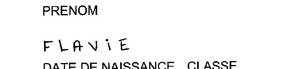
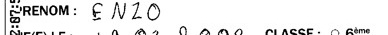
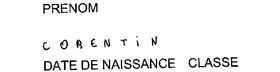
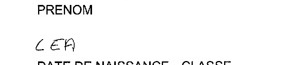
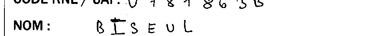
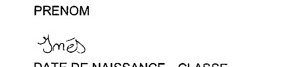
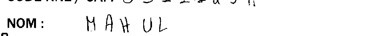
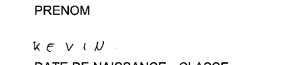
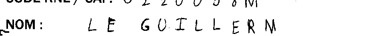
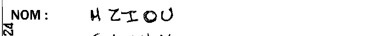
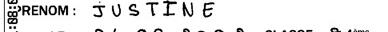
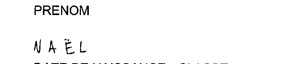
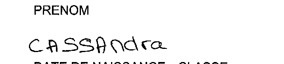
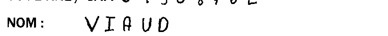
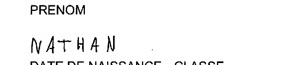
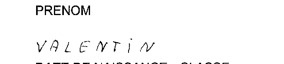
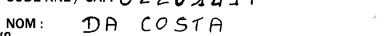
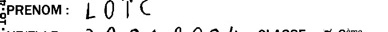
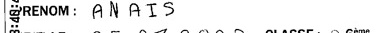
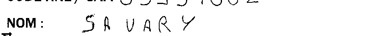
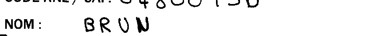
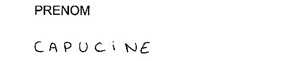
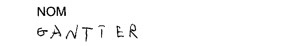
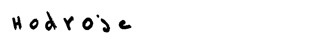
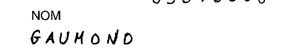
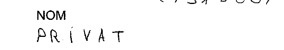
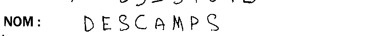
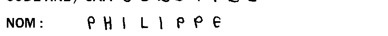
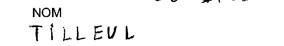
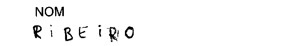
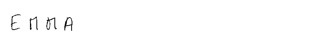
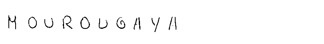
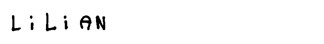
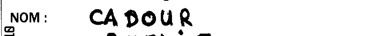
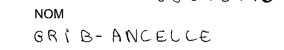
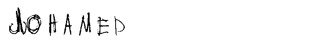
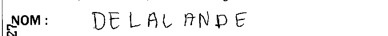
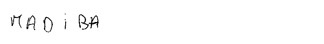
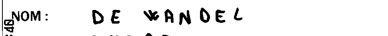
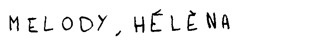
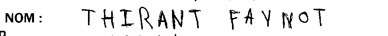
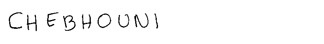
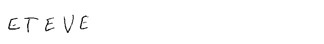
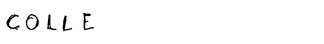
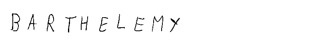
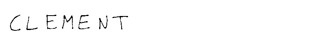
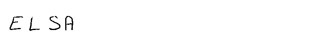
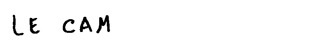

In [7]:
#This cell is here to help in post-hoc analysis: by knowing how the model is failing, we can get ideas on how to improve  
#You can play around with slicing up the dataframe etc
#Note that this is for the kaggle data, based on the input arg in tesstest.test_model("kaggle" . . . )

import pandas as pd

#Some libraries to help the PIL image object be rendered in the dataframe
from IPython.display import Image, HTML
from PIL import Image
from io import BytesIO
import base64

#More Preprocessing resources
import jiwer #This is the library used to compute the error rates

character_error_list = []
for item in range(0, len(test_extractions)):
    
    ground_truth_instance = test_image_labels[item]
    hypothesis_instance = test_extractions[item]
    character_error_list.append(jiwer.cer(ground_truth_instance, hypothesis_instance))

test_results_df = pd.DataFrame(
    {'images': image_list,
     'labels': test_image_labels,
     'extractions(model_output)': test_extractions,
     'character_error_rate': character_error_list})

test_results_df.sort_values(by = ['character_error_rate'], inplace = True, ascending = False) #As an example of doing some investigation of the output

#This function and the below help make it so PIL objects have "Links" associated with them, so that we can get them
#to render in the dataframe
def to_data_uri(pillow_img):
    img_buffer = BytesIO()
    pillow_img.save(img_buffer, format="PNG")
    return "data:image/png;base64," + base64.b64encode(img_buffer.getvalue()).decode('utf-8')

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ to_data_uri(path) + '" width="350" height = "350" >'

pd.set_option('display.max_colwidth', None)




# Create the dictionariy to be passed as formatters
image_cols = ['images']
format_dict = {}
for image_col in image_cols:
    print(image_col)
    format_dict[image_col] = path_to_image_html

display(HTML(test_results_df.iloc[0:100,::].to_html(escape=False ,formatters=format_dict)))

,images,labels,extractions(model_output),character_error_rate
70,,DA COSTA,\n,1.000000
29,,LYNN,\n,1.000000
42,,LOIC,\n,1.000000
43,,DODOVAN,FRNOM:DODOVRAN\n,1.000000
31,,ANAIS,\n,1.000000
10,,HUGO,\n,1.000000
44,,CECILE,\n,1.000000
28,,HUGO,\n,1.000000
2,,SAVARY,\n,1.000000
46,,NAIL,,1.000000

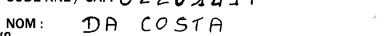
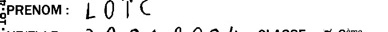
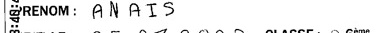
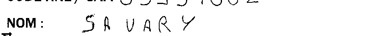
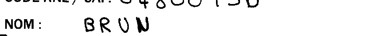
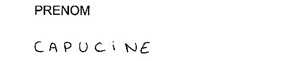
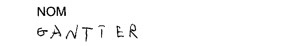
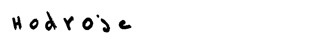
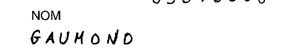
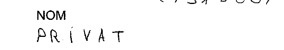
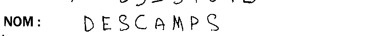
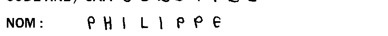
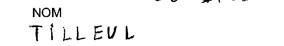
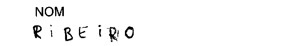
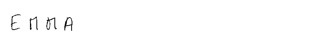
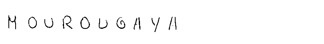
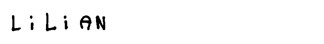
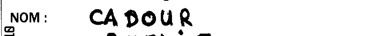
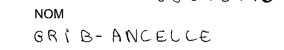
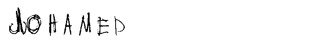
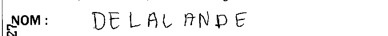
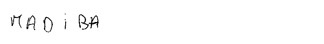
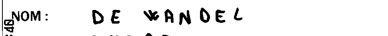
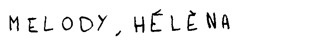
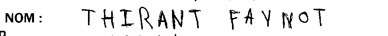
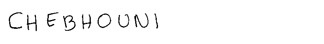
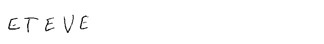
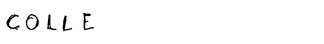
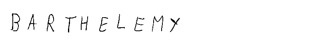
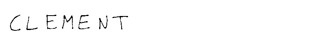
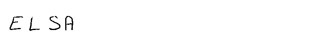
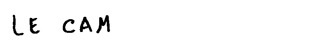

In [8]:
#character error rate as seen above overflows above 1.0 error rate, which in a sense really warps
#our perception of the actuall error rate.

#It may also be contributing to having strange effects on how the Tesseract model is working
#Below is a trimmed version of the dataframe


test_results_trimmed_df = test_results_df[test_results_df['character_error_rate'] <= 1.0]

display(HTML(test_results_trimmed_df.iloc[0:100,::].to_html(escape=False ,formatters=format_dict)))

In [9]:
#Additional emphasis on how the error rate not being capped is skewing the data
#Also notice the difference of this cell output and the one below it.  This one is more of an average across each word, the one 
#below is the average if you put all the characters into one bag.

print(test_results_df['character_error_rate'].mean())
print(test_results_trimmed_df['character_error_rate'].mean())

0.8882031470639064
0.45419692393376604


In [10]:
print(f"Word Error Rate of {round(100 *word_error_rate, 2)}% and Character Error Rate of {round(100 *char_error_rate, 2)}%")

Word Error Rate of 100.0% and Character Error Rate of 80.43%


In [11]:
#For a future pull request I'm going to work on the garbage in problem of this data as well as a correct test-train split.